## Data Preparation

In PyTorch, `Dataset` and `DataLoader` in `torch.utils.data` are used for data preparation.

- `Dataset` contains (MNIST, FashionMNIST, CIFAR10, ...)
  - Vision Dataset: https://pytorch.org/vision/stable/datasets.html
  - Text Dataset: https://pytorch.org/text/stable/datasets.html
  - Audio Dataset: https://pytorch.org/audio/stable/datasets.html
  - We can determine how to load data through `Dataset`, `batch_size`, `train`, `transform` parameters in `DataLoader`

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import time

print(torch.__version__)

2.0.0


`torchvision` provide vision-related dataset

- `transforms`: method for preprocessing (https://pytorch.org/docs/stable/torchvision/transforms.html)
- Usually, make new class for transform and use it.


In [2]:
import torchvision.transforms as transforms
from torchvision import datasets

`DataLoader`의 인자로 들어갈 `transform`을 미리 정의할 수 있고, `Compose`를 통해 리스트 안에 순서대로 전처리 진행

`ToTensor`()를 하는 이유는 `torchvision`이 PIL Image 형태로만 입력을 받기 때문에 데이터 처리를 위해서 Tensor형으로 변환 필요

In [3]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std = (1.0, ))])

In [4]:
trainset = datasets.MNIST(root='./content/',
                          train=True, download=True,
                          transform = mnist_transform)
testset = datasets.MNIST(root='./content/',
                          train=False, download=True,
                          transform = mnist_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 12336479.17it/s]


Extracting ./content/MNIST/raw/train-images-idx3-ubyte.gz to ./content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111851979.52it/s]


Extracting ./content/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17383119.30it/s]


Extracting ./content/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21846936.66it/s]

Extracting ./content/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/MNIST/raw



`DataLoader`는 데이터 전체를 보관했다가 실제 모델 학습을 할 때 `batch_size` 크기만큼 데이터를 가져옴

In [5]:
#batch size
bs = 8
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images.shape, labels.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [7]:
torch_image = torch.squeeze(images[0])
torch_image.shape

torch.Size([28, 28])

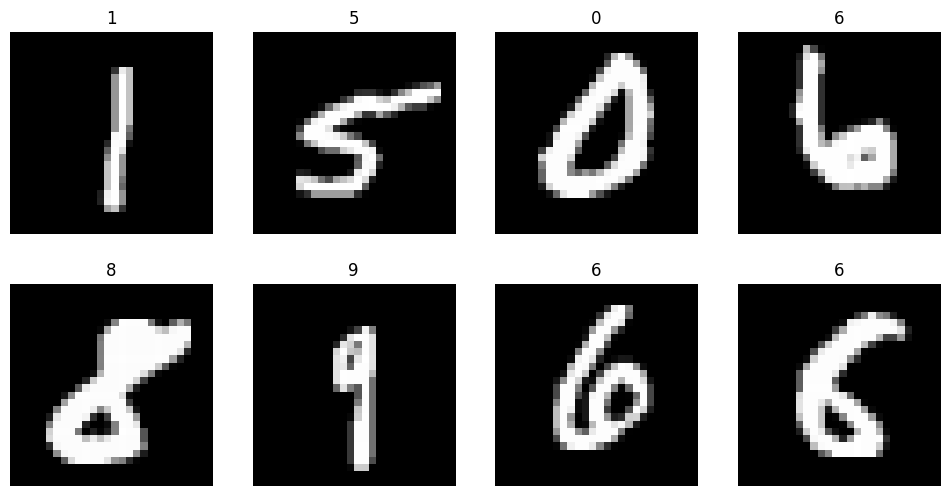

In [8]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 6))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(trainset), size=(1, )).item()
  img, label = trainset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## MNIST Classification Model

GPU 설정

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Loading Data

In [10]:
train_loader = DataLoader(trainset, batch_size = 128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size = 128, shuffle=False, num_workers=2)

In [11]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [27]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 16, 2, 1, 1)
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        return x 

In [13]:
model = CNN_Model()
print(model)

CNN_Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [35]:

epochs = 5
losses = []
for epoch in range(1, epochs + 1):
    start = time.time()
    total_loss = 0
 
    #for xb, yb in train_loader:
    for xb, yb in tqdm(train_loader):
        pred = model(xb)
        loss = criterion(pred, yb.long())
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        total_loss += loss.item()
    print(f"epoch {epoch}/{epochs} Loss = {loss.item()}")
    
    correct = 0
    total   = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        print(f"{time.time() - start} sec - acc : {acc} %")

100%|██████████| 469/469 [01:03<00:00,  7.37it/s]

epoch 1/5 Loss = 0.015405458398163319


65.18004608154297 sec - acc : 98.33 %


100%|██████████| 469/469 [01:10<00:00,  6.66it/s]

epoch 2/5 Loss = 0.0022374435793608427


72.2155613899231 sec - acc : 98.4 %


100%|██████████| 469/469 [01:05<00:00,  7.14it/s]

epoch 3/5 Loss = 0.13770116865634918


67.34073805809021 sec - acc : 98.4 %


100%|██████████| 469/469 [01:03<00:00,  7.42it/s]

epoch 4/5 Loss = 0.06318273395299911


64.79645776748657 sec - acc : 98.34 %


100%|██████████| 469/469 [01:01<00:00,  7.57it/s]

epoch 5/5 Loss = 0.014957382343709469


63.54617381095886 sec - acc : 98.12 %


In [17]:
!pip install torchsummary
from torchsummary import summary

In [29]:
print(summary(model, (28, 28)))
print(28 - 3 + 2 * 1 + 1)
print(3 * 3 * 32 + 32)
print(2*2*32*16 + 16)
print(7*7*16*10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 16, 15, 15]           2,064
            Linear-3                   [-1, 10]           7,850
Total params: 10,234
Trainable params: 10,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.04
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
None
28
320
2064
7840
